In [1]:
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt

In [2]:
# Create color palette
color_dict = {
    "EPI":  [73, 0, 106],
    "GLD":  [108, 0, 115],
    "INF":  [145, 1, 122],
    "RET":  [181, 9, 130],
    "FOL":  [216, 47, 148],
    "PAP":  [236, 85, 157],
    "HYP":  [254, 246, 242],
    "KER":  [248, 123, 168],
    "BKG":  [0, 0, 0],
    "BCC":  [127, 255, 255],
    "SCC":  [127, 255, 142],
    "IEC":  [255, 127, 127]
}

LUT = {
      0 : "EPI",
      1 : "GLD",
      2 : "INF",
      3 : "RET",
      4 : "FOL",
      5 : "PAP",
      6 : "HYP",
      7 : "KER",
      8 : "BKG",
      9 : "BCC",
      10 : "SCC",
      11: "IEC"
}

rev_LUT = {v: k for k, v in LUT.items()}

In [3]:
def convert_RGB_to_8bit(image):
    """ returns the 8 bit encoding of the image based on the LUT and color_dict order"""
    segmentation_8bit = np.zeros((image.shape[0], image.shape[1]), dtype="uint8")
    for i in range(12):
        segmentation_8bit[np.all(image == color_dict[LUT[i]], axis=-1)] = i
    return segmentation_8bit

def convert_8bit_to_RGB(image):
    """ returns the rgb encoding of the 8-bit image based on the LUT and color_dict order"""
    segmentation_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype="uint8")
    for i in range(12):
        segmentation_rgb[image == i] = color_dict[LUT[i]]
    return segmentation_rgb

In [4]:
from skimage.measure import label, regionprops, find_contours

In [5]:
# Close it
from skimage.morphology import closing, square

In [6]:
# Fill background to remove inner rubbish...
from scipy.ndimage.morphology import binary_fill_holes, distance_transform_edt

<hr>

In [25]:
image = imread("/home/simon/Desktop/Excisions/test/BCC_90.png")
histo_image = imread("/home/simon/Documents/PhD/Data/Histo_Segmentation/Datasets_n290/10x/Images/BCC_90.tif")

In [8]:
image_8bit = convert_RGB_to_8bit(image)

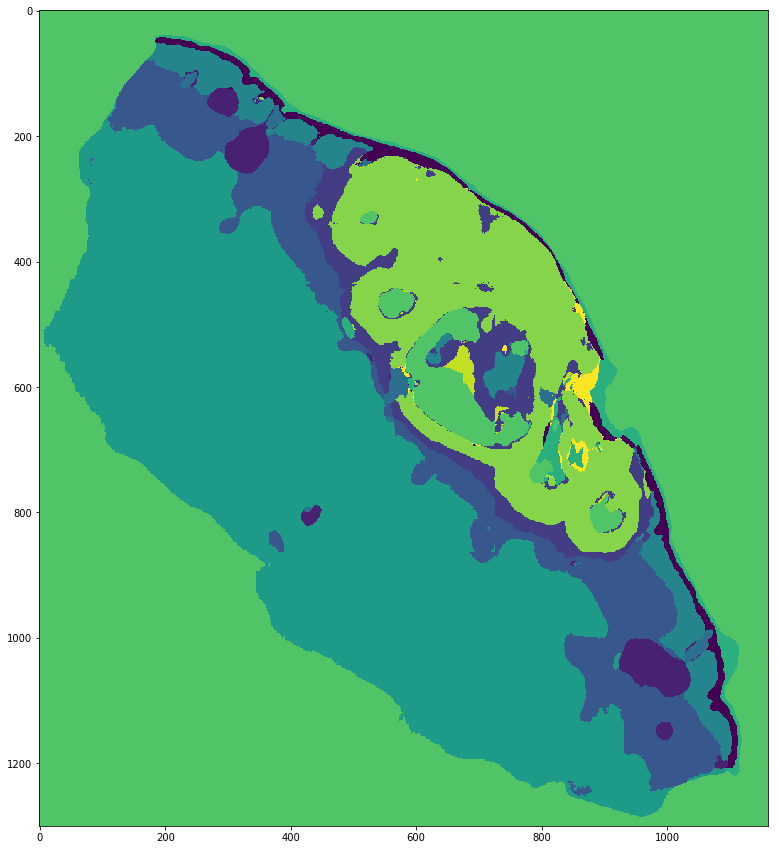

In [9]:
fig = plt.figure( figsize=(15, 15))
plt.imshow(image_8bit);

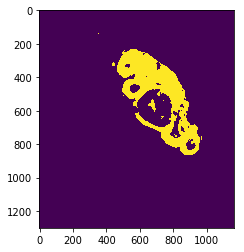

In [10]:
cancer = (image_8bit == 9) + (image_8bit == 10) + (image_8bit == 11)
plt.imshow(cancer);

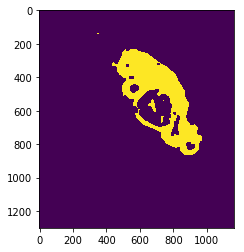

In [11]:
cancer = closing(cancer, square(15))
plt.imshow(cancer);

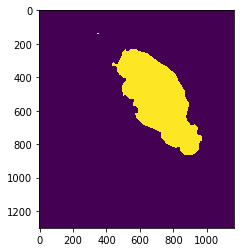

In [12]:
binary_fill_holes(cancer, output=cancer)
plt.imshow(cancer);

Do the same for BKG

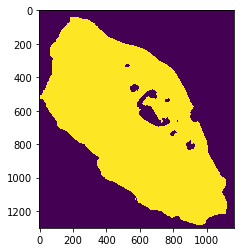

In [13]:
background = ~(image_8bit == 8)
plt.imshow(background);

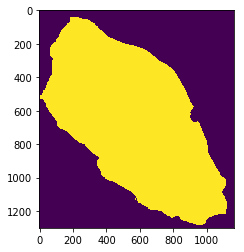

In [14]:
binary_fill_holes(background, output=background)
plt.imshow(background);

In [15]:
# Get distance from cancer margins
distance = distance_transform_edt(~cancer)

In [16]:
ppmm = 0.00067
green = (15/255., 1, 16/255.)

In [17]:
# Convert distance to mm
image_factor = 10
distance *= (ppmm * image_factor)

In [18]:
# Get range of distances
np.min(distance), np.max(distance)

(0.0, 5.847944845841144)

In [19]:
# Set things outside of tissue to 0
distance[~background] = 0

In [20]:
# Use the median value to determine clearance
clearance = np.round(np.median(distance[background]), 1) # mm

# Get the points for background, cancer and margins
background_perimeter = np.concatenate(find_contours(background, level=0.5)).astype("int")
cancer_perimeter = np.concatenate(find_contours(cancer, level=0.5)).astype("int")
margin_perimeter = np.concatenate(find_contours(distance, level=clearance)).astype("int")

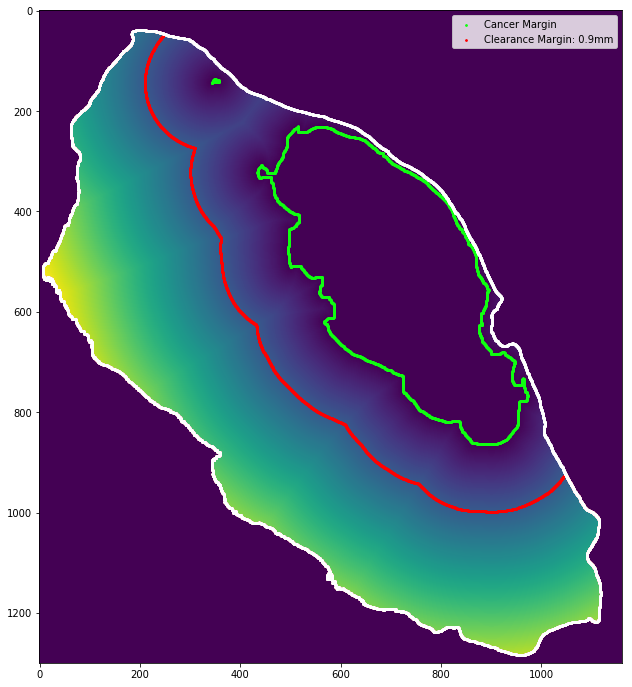

In [33]:

fig = plt.figure(figsize=(12, 12))

plt.imshow(distance);

# Show cancer
plt.scatter(cancer_perimeter[:, 1], cancer_perimeter[:, 0], color=green, s=3, label="Cancer Margin")

# Show clearance
plt.scatter(margin_perimeter[:, 1], margin_perimeter[:, 0], s=3, color="red", label="Clearance Margin: {}mm".format(clearance))

# Show background
plt.scatter(background_perimeter[:, 1], background_perimeter[:, 0], color="white", s=4)

#plt.title("Median clearnance : {0}mm".format(clearance))

plt.legend()

plt.show()